## Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

import os
import sys

sys.path.append(os.path.abspath('..'))

import torch
from src.models.GaussianProcess import GaussianProcessRegressor, SinusoidalKernel, RBFKernel

## Data Generation Function

In [2]:
amplitude = 1
period = np.pi/2

def f(x):
    return amplitude * torch.sin(period * x)


## Generating Data

In [10]:
lower_in = 0
upper_in = 10
num_train = 10
noise = 0.6
x_train = torch.cat([torch.linspace(lower_in, 4, num_train), torch.linspace(6, upper_in, num_train)]).unsqueeze(1)
y = f(x_train)

homoscedastic_noise = torch.randn_like(y) * noise**2
heteroscedastic_noise = torch.tensor(np.random.normal(loc=0, scale=x_train.detach().numpy()*noise**2))

x_train = x_train.to(torch.device('cuda')).to(torch.float64)
y_train = (y).to(torch.device('cuda')).to(torch.float64)

## Creating Gaussian Process

In [13]:
kernel_exp = RBFKernel(length_scale=1.0, amplitude=5.0).to(torch.device('cuda'))

gp_exp = GaussianProcessRegressor(kernel_exp, noise=1.0, max_iter=4_000, batch_size=num_train*2, lr=0.004, delta=1e-6)
gp_exp = gp_exp.fit(x_train, y_train)

print(gp_exp.noise)
print(gp_exp.kernel.get_params())
print(gp_exp.noise)

Training noise
Iteration      0, Loss:      42.97
Iteration     50, Loss:      40.61
Iteration    100, Loss:      38.30
Iteration    150, Loss:      36.06
Iteration    200, Loss:      33.93
Iteration    250, Loss:      31.98
Iteration    300, Loss:      30.15
Iteration    350, Loss:      28.38
Iteration    400, Loss:      26.61
Iteration    450, Loss:      24.82
Iteration    500, Loss:      23.00
Iteration    550, Loss:      21.16
Iteration    600, Loss:      19.33
Iteration    650, Loss:      17.56
Iteration    700, Loss:      15.99
Iteration    750, Loss:      14.80
Iteration    800, Loss:      14.22
Iteration    850, Loss:      14.22
Iteration    900, Loss:      14.22
Iteration    950, Loss:      14.22
Iteration   1000, Loss:      14.22
Iteration   1050, Loss:      14.22
Iteration   1100, Loss:      14.22
Iteration   1150, Loss:      14.22
Iteration   1200, Loss:      14.22
Iteration   1250, Loss:      14.22
Iteration   1300, Loss:      14.22
Iteration   1350, Loss:      14.22
Itera

## Plotting GP Samples

torch.Size([30, 1500])


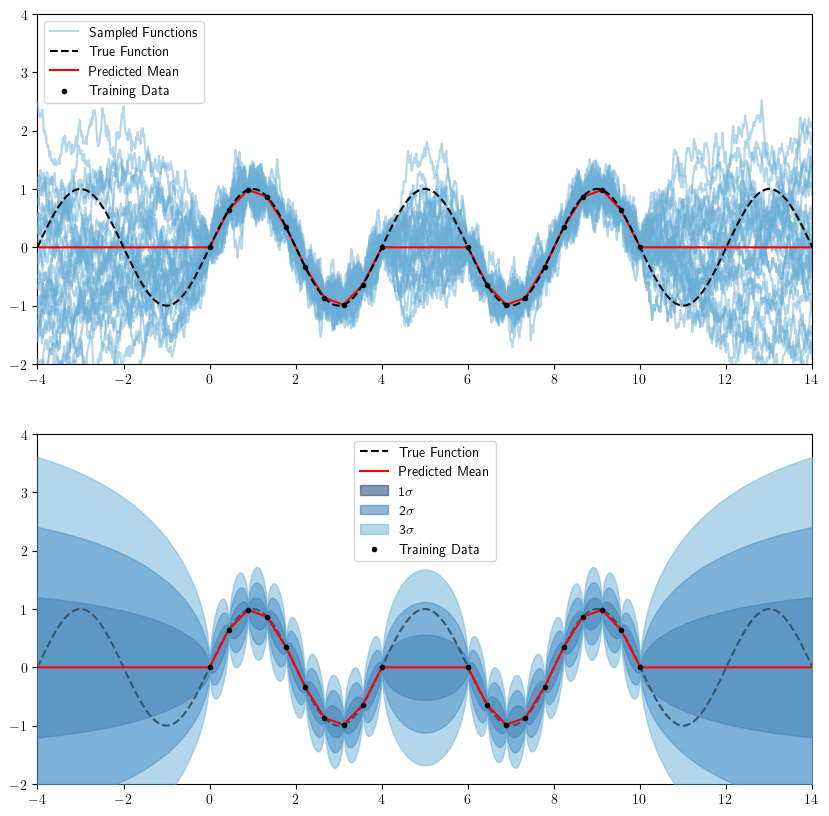

In [14]:
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()


cmap = plt.get_cmap('Blues')
colors = list(reversed([cmap(i) for i in np.linspace(0.5, 1, 3)]))
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 10))
#fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

x_test = torch.linspace(-4, 14, 1500, device=torch.device('cuda')).unsqueeze(1)

y_pred, y_std = gp_exp.predict(x_test, return_std=True)
y_samples = gp_exp.predict(x_test, num_samples=30)

print(y_samples.shape)

for i, sample in enumerate(y_samples):
    ax0.plot(to_numpy(x_test), to_numpy(sample), c=colors[2], alpha=0.5, zorder=i*5)

ax0.plot(to_numpy(x_test), to_numpy(y_samples[-1]), c=colors[2], alpha=0.5, label='Sampled Functions')

ax0.plot(np.linspace(lower_in-4, upper_in+4, 1000), f(torch.linspace(lower_in-4, upper_in+4, 1000)), c='black', linestyle="dashed", label='True Function', zorder=175)
ax0.plot(to_numpy(x_test), to_numpy(y_pred), 'r', label='Predicted Mean', zorder=160)
ax1.plot(np.linspace(lower_in-4, upper_in+4, 1000), f(torch.linspace(lower_in-4, upper_in+4, 1000)), c='black', linestyle="dashed", label='True Function', zorder=15)
ax1.plot(to_numpy(x_test), to_numpy(y_pred), 'r', label='Predicted Mean', zorder=20)




for i, color in zip([1,2,3], colors):
    upper = y_pred.squeeze() + i * y_std
    lower = y_pred.squeeze() - i * y_std

    ax1.fill_between(to_numpy(x_test).squeeze(), to_numpy(upper), to_numpy(lower), alpha=0.5, color=color, label= f"{i}" + r'$\sigma$', zorder=i*5)

ax0.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), c='black', marker='.', label='Training Data', zorder=200)
ax1.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), c='black', marker='.', label='Training Data', zorder=25)

ax0.set_xlim(-4, 14)
ax0.set_ylim(-2, 4)
ax1.set_xlim(-4, 14)
ax1.set_ylim(-2, 4)

ax0.legend()
ax1.legend()

plt.show()

## Coin Flip Example

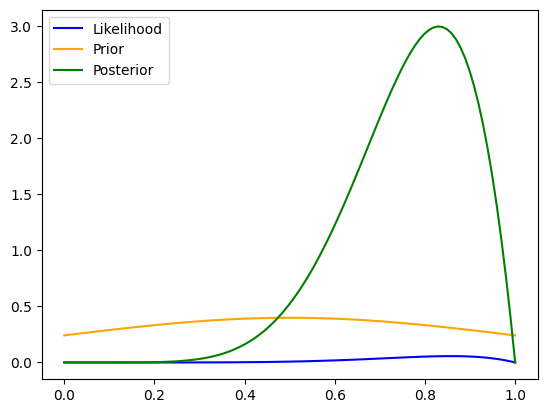

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def likeihood(p, D):
    a, b = D
    return p**a * (1 - p)**b

def prior(p):
    bounds = (0 <= p) & (p <= 1) 
    gaus_like = (1/np.sqrt(2*np.pi)) * np.exp(-(p - .5)**2/(2*.25))# Uniform prior over [0, 1]
    return gaus_like * bounds

def unif_posterior(p):
    return p**5

# Define the range of p values
D = (6,1)
p_values = np.linspace(0, 1, 100)
likelihood_values = likeihood(p_values, D)
prior_values = prior(p_values)
unnormalized_posterior_values = prior_values * likelihood_values
posterior_values = unnormalized_posterior_values / np.trapz(unnormalized_posterior_values, p_values)

plt.plot(p_values, likelihood_values, label='Likelihood', color='blue')
plt.plot(p_values, prior_values, label='Prior', color='orange')
plt.plot(p_values, posterior_values, label='Posterior', color='green')
plt.legend()
plt.show()

## Confidence vs Credible Intervals

Sample 37: 1.1032 ± 0.1004 does not contain the true mean 1.00
Sample 75: 1.1809 ± 0.1411 does not contain the true mean 1.00
Sample 77: 1.1796 ± 0.1683 does not contain the true mean 1.00
Sample 91: 0.8069 ± 0.1341 does not contain the true mean 1.00
Sample 104: 1.1877 ± 0.1802 does not contain the true mean 1.00
Sample 111: 1.1930 ± 0.1682 does not contain the true mean 1.00
Sample 113: 1.1417 ± 0.1191 does not contain the true mean 1.00
Sample 129: 0.8044 ± 0.1864 does not contain the true mean 1.00
Sample 168: 1.1704 ± 0.0673 does not contain the true mean 1.00
Sample 199: 0.8685 ± 0.1236 does not contain the true mean 1.00
Sample 258: 0.7922 ± 0.1406 does not contain the true mean 1.00
Sample 268: 1.1515 ± 0.1134 does not contain the true mean 1.00
Sample 294: 1.2028 ± 0.1870 does not contain the true mean 1.00
Sample 296: 0.8837 ± 0.1080 does not contain the true mean 1.00
Sample 325: 1.2131 ± 0.1998 does not contain the true mean 1.00
Sample 393: 1.1401 ± 0.1088 does not contain

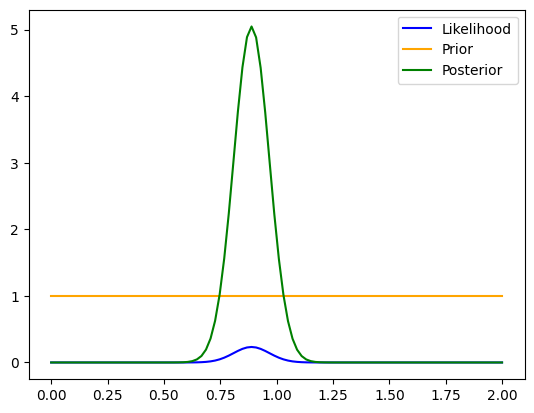

In [20]:
import numpy as np
import matplotlib.pyplot as plt

mu = 1
sigma = 0.25
sample_size = 10
c = 2.262  # for 95% confidence interval

num_samples = 10000

contains = 0

for i in range(num_samples):
    sample = np.random.normal(mu, sigma, sample_size)
    sample_mean = np.mean(sample)
    sample_std = np.std(sample, ddof=1)  # Sample standard deviation
    lower_bound = sample_mean - (c * sample_std / np.sqrt(sample_size))
    upper_bound = sample_mean + (c * sample_std / np.sqrt(sample_size))
    if lower_bound <= mu <= upper_bound:
        contains += 1
    else:
        print( f"Sample {i+1}: {sample_mean:.4f} ± {c * sample_std / np.sqrt(sample_size):.4f} does not contain the true mean {mu:.2f}")

print(f"{contains/num_samples:.2%} of the samples contained the true mean {mu:.2f} within the 95% confidence interval.")


def likelihood(samples, mu, sigma):
    samp_copy = samples.copy()

    prob = np.exp(-0.5 * ((samp_copy - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
    return np.prod(prob)  # Return the product of probabilities for all samples

def prior(mu):
    # Assuming a uniform prior over mu in the range [0, 1]
    return 1.0 if 0 <= mu <= 2 else 0.0

mu_s = np.linspace(0, 2, 100)  # Range of mu values to evaluate
samples = np.random.normal(mu, sigma, sample_size)

likelihoods = np.array([likelihood(samples, mu_val, sigma) for mu_val in mu_s])
priors = np.array([prior(mu_val) for mu_val in mu_s])
# Normalize the likelihoods to avoid numerical issues
posterior = likelihoods * priors
posterior /= np.trapz(posterior, mu_s)  # Normalize the posterior distribution

plt.plot(mu_s, likelihoods, label='Likelihood', color='blue')
plt.plot(mu_s, priors, label='Prior', color='orange')
plt.plot(mu_s, posterior, label='Posterior', color='green')

plt.legend()
plt.show()

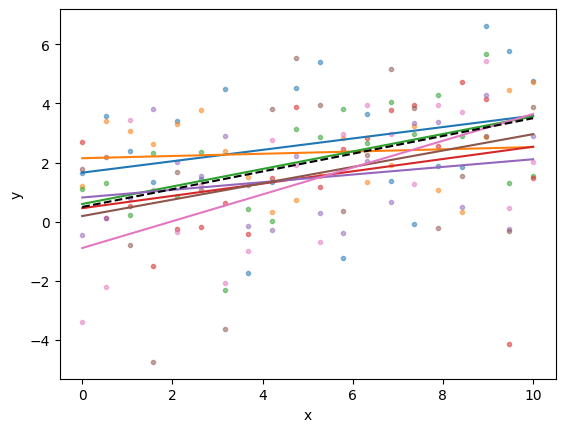

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge

def f(x):
    return 0.3 * x + 0.5


def get_dataset(num=20, noise=2):
    lower_in = 0
    upper_in = 10
    x_train = np.linspace(lower_in, upper_in, num).reshape(-1, 1)
    y = f(x_train)

    homoscedastic_noise = np.random.normal(loc=0, scale=noise, size=y.shape) 

    x_train = x_train
    y_train = y + homoscedastic_noise

    return x_train, y_train

num_ds = 7
x_true = np.linspace(0, 10, 100).reshape(-1, 1)
y_true = f(x_true)

for i in range(num_ds):
    x_train, y_train = get_dataset()
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_train)
    plt.scatter(x_train, y_train, label=f'Dataset {i+1}', marker='.', alpha=0.5)
    plt.plot(x_train, y_pred)

plt.plot(x_true, y_true, c='black', linestyle="dashed", label='True Function')

plt.xlabel('x')
plt.ylabel('y')
plt.show()


torch.Size([30, 2]) torch.Size([30])
Iteration 0: Loss = 98.35253703594208
Iteration 100: Loss = 83.13828921318054
Iteration 200: Loss = 72.79300272464752
Iteration 300: Loss = 60.68808901309967
Iteration 400: Loss = 51.730432987213135
Iteration 500: Loss = 39.482953786849976
Iteration 600: Loss = 46.90171813964844
Iteration 700: Loss = 46.009175539016724
Iteration 800: Loss = 40.48557150363922
Iteration 900: Loss = 21.309184908866882
Iteration 1000: Loss = 23.832160234451294
Iteration 1100: Loss = 7.325068712234497
Iteration 1200: Loss = 34.38703691959381
Iteration 1300: Loss = 14.991220712661743
Iteration 1400: Loss = 11.283121824264526
Iteration 1500: Loss = 8.595387697219849
Iteration 1600: Loss = 13.201454043388367
Iteration 1700: Loss = -7.395808100700378
Iteration 1800: Loss = 6.028942942619324
Iteration 1900: Loss = 53.56318402290344
Iteration 2000: Loss = -8.121103048324585
Iteration 2100: Loss = -2.7970521450042725
Iteration 2200: Loss = 2.493232011795044
Iteration 2300: Loss

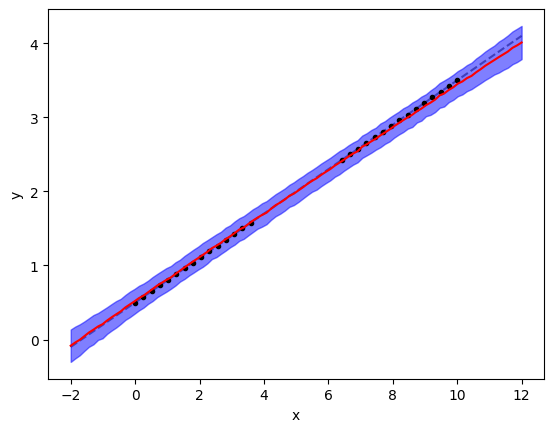

In [79]:
import pyro
import torch
from pyro.nn import PyroSample, PyroModule
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
from torch import nn

class BayesianRegression(PyroModule):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = PyroModule[nn.Linear](input_dim, output_dim)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([output_dim, input_dim]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([output_dim]).to_event(1))
    
    def forward(self, x, y_train=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y_train)
        return mean



x_train, y_train = get_dataset(num=40, noise=0.0)

x_train = np.concatenate([x_train[:15], x_train[25:]])
y_train = np.concatenate([y_train[:15], y_train[25:]])

x_train = torch.tensor(x_train).float()
x_train = torch.cat([ x_train**2, x_train], dim=1)
y_train = torch.tensor(y_train).squeeze().float()

print(x_train.shape, y_train.shape)

model = BayesianRegression(input_dim=2, output_dim=1)
adam = pyro.optim.Adam({"lr": 0.01})
guide = AutoMultivariateNormal(model)
svi = SVI(model, guide, adam, loss=Trace_ELBO())
num_iterations = 3000

pyro.clear_param_store()
for j in range(num_iterations):
    loss = svi.step(x_train, y_train)
    if j % 100 == 0:
        print(f"Iteration {j}: Loss = {loss}")

predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1000, return_sites=["obs", "_RETURN"])

x_test = torch.linspace(-2, 12, 100).unsqueeze(1).float()
x_in = torch.cat([x_test**2, x_test], dim=1)

samples = predictive(x_in)

y_true = f(x_test)

preds = samples["obs"]
pred_linear = samples["_RETURN"]
print(preds.shape)
mean = preds.mean(0)
std = preds.std(0)

plt.plot(x_test, mean, label='Mean Prediction', color='red')
plt.fill_between(x_test.squeeze(), mean - std, mean + std, alpha=0.5, color='blue', label='Uncertainty Interval')

plt.scatter(x_train[:,1], y_train, label='Training Data', marker='.', c='black')
plt.plot(x_test, y_true, c='black', linestyle="dashed", label='True Function', zorder=0, alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

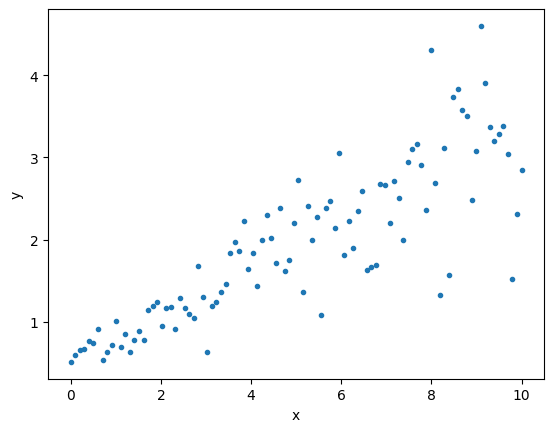

In [69]:
x = np.linspace(0, 10, 100)
y = f(torch.tensor(x)).numpy()
homoscedastic_noise = np.random.normal(loc=0, scale=0.1, size=y.shape)
heteroscedastic_noise = np.random.normal(loc=0, scale=x*0.1)
y = y + homoscedastic_noise + heteroscedastic_noise

plt.scatter(x, y, label='Data', marker='.')
plt.xlabel('x')
plt.ylabel('y')
plt.show()